# Step 0. Import libraries

In [2]:
import os
import random
import numpy as np
import tarfile
import sys
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.contrib.slim.python.slim.nets import inception_v3
import matplotlib.pyplot as plt
%matplotlib inline

# Step 1. Uncompress the image folder

In [3]:
num_classes = 3
train_filename = 'training-images.tar.gz'

def do_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0] # remove .tar.gz
    if os.path.isdir(root) and not force:
        print('%s already exists. Skipping extracting %s.' % (root, filename))
    else:
        print('Extracting data for %s...' % root)
        tar = tarfile.open(filename, "r:gz")
        tar.extractall()
        tar.close()
    data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = do_extract(train_filename)

training-images already exists. Skipping extracting training-images.tar.gz.
['training-images/couches', 'training-images/mattresses', 'training-images/tv-monitor']


In [4]:
def do_remove(folder):
    image_files = os.listdir(folder)
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image = Image.open(image_file)
        except IOError as e:
            os.remove(image_file)
            print('Removed %s' % image_file)

do_remove('training-images/couches/')
do_remove('training-images/mattresses/')
do_remove('training-images/tv-monitor/')

# Define Image preprocessing pipeline - Image Augmentation

In [7]:
import cv2
def flipImg(image):
    """
        Flipping Image
        
        Args:
            image (arr): image matrix
            
        Retruns:
            image matrix
    """
    
    flipImg = image.copy()
    flipImg = cv2.flip(image, 1)
    
    return flipImg

def brightnessImg(image):
    """
        Raondomly adjust brightness of image
        
        Args:
            image (arr): image matrix

        Returns:
            image matrix
    """
    
    imgCopy = image.copy()
    randomValue = np.random.uniform() + 0.3
    birghtnessImgHSV = cv2.cvtColor(imgCopy, cv2.COLOR_BGR2HSV)
    birghtnessImgHSV[:,:, 2] = birghtnessImgHSV[:,:, 2] * randomValue
    ImgBGR =  cv2.cvtColor(birghtnessImgHSV, cv2.COLOR_HSV2BGR)
    ImgRGB = cv2.cvtColor(ImgBGR, cv2.COLOR_BGR2RGB)

    return ImgRGB

def colorJittering(image):
    """
        Randomly shift some pixels around
    """
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # cv2 defaul color code is BGR
    h,w,c = img.shape # (299, 299, 3)

    noise = np.random.randint(0,50,(h, w)) # design jitter/noise here
    zitter = np.zeros_like(img)
    zitter[:,:,1] = noise  

    noise_added = cv2.add(img, zitter)
    #combined = np.vstack((img[:h/2,:,:], noise_added[h/2:,:,:]))
    return noise_added

def shiftChannel(image):
    '''
        Shift each channel by 10 pixels
    '''
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # cv2 defaul color code is BGR
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    RGBshifted = np.dstack( (
        np.roll(R, 10, axis=0), 
        np.roll(G, 10, axis=1), 
        np.roll(B, -10, axis=0)
    ))
    
    return RGBshifted

def randCrop(image):
    '''
        Randomly crop the image
    '''
    img = image.copy()
    w,h = img.size # (299, 299)
    corner_x = np.random.randint(0, 149) # randomly choose left-up corner in left-up quater area
    corner_y = np.random.randint(0, 149)
    temp_img = img.crop(
        (
            corner_x,
            corner_y,
            w,
            h
        )
    )
    crop_img = temp_img.resize((w, h), Image.ANTIALIAS)
    return crop_img

# def driftImg(image):
#     """
#         Working on this
#         TODO: define drifting mathod for image augmentation
#     """

NameError: name 'img_4' is not defined

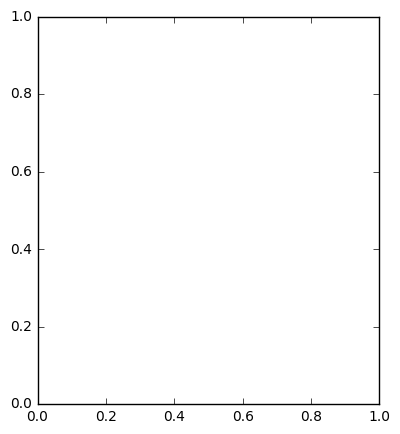

In [8]:
path_4 = 'training-images/tv-monitor/'
fig = plt.figure(figsize=(15,5))
img_4_name = random.choice([x for x in os.listdir(path_4) if os.path.isfile(os.path.join(path_4, x))])
img_4_pil = Image.open(os.path.join(path_4,img_4_name)) # read by PIL
img_4_numpy = cv2.imread(path_4 + img_4_name) # read by numpy as array
flip_Img = flipImg(img_4_numpy)
bright_Img = brightnessImg(img_4_numpy)
jittering_Img = colorJittering(img_4_numpy)
shiftChannel_Img = shiftChannel(img_4_numpy)
crop_Img = randCrop(img_4_pil)

plt.subplot(131)
plt.imshow(img_4_numpy)
plt.subplot(132)
plt.imshow(flip_Img)
plt.subplot(133)
plt.imshow(crop_Img)


In [ ]:
# test to see if uncompressing is done properly
path_1 = 'training-images/couches/'
path_2 = 'training-images/mattresses/'
path_3 = 'training-images/tv-monitor/'

fig = plt.figure(figsize=(15,5))
img_1_name = random.choice([x for x in os.listdir(path_1) if os.path.isfile(os.path.join(path_1, x))])
img_2_name = random.choice([x for x in os.listdir(path_2) if os.path.isfile(os.path.join(path_2, x))])
img_3_name = random.choice([x for x in os.listdir(path_3) if os.path.isfile(os.path.join(path_3, x))])
img_1 = Image.open(os.path.join(path_1,img_1_name))
img_2 = Image.open(os.path.join(path_2,img_2_name))
img_3 = Image.open(os.path.join(path_3,img_3_name))

plt.subplot(131)
plt.imshow(img_1)
plt.title('couches', fontsize=12)

plt.subplot(132)
plt.imshow(img_2)
plt.title('mattresses', fontsize=12)

plt.subplot(133)
plt.imshow(img_3)
plt.title('tv-monitor', fontsize=12)

# Step 2. Create the dataset 

In [ ]:
inception_size = inception_v3.inception_v3.default_image_size
image_width, image_height = inception_size, inception_size

def do_load(folder, min_num_images, bg_colour=(255, 255, 255)):
    image_count = 0
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_height, image_width, 3), dtype=np.uint8)
    for image in image_files:
        file_name, file_extension = os.path.splitext(image)
        image_file = os.path.join(folder, image)
        try:
            img = Image.open(image_file)
            # image preprocessing: resize
            img = img.resize((image_width, image_height), Image.ANTIALIAS)
            img = img.convert("RGB")
            img.save(folder + '/' + file_name + '.jpg','JPEG')
            image_data = np.array(img, dtype=np.float64)
            # image preprocessing: scale
            image_data -= np.mean(image_data, axis = 0) # zero center
            image_data /= np.std(image_data + 1e-5, axis = 0) # normalize
            if image_data.shape != (image_height, image_width, 3):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[image_count] = image_data
            image_count += 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '. Skipped reading.')
    
    if image_count < min_num_images:
        raise Exception('Fewer images than expected: %d < %d' %(image_count, min_num_images))
    
    print('Full dataset size:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset), '\n')
    
    return dataset

# Step 3. Pickle the dataset

In [ ]:
def do_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        pickle_filename = folder + '.pickle'
        dataset_names.append(pickle_filename)
        if os.path.exists(pickle_filename) and not force:
            print('%s already exists. Skipped pickling.' % pickle_filename)
        else:
            print('Pickling %s...' % pickle_filename)
            dataset = do_load(folder, min_num_images_per_class)
            try:
                with open(pickle_filename, 'wb') as f:
                    pickle.dump(dataset, f)
            except Exception as e:
                print('Unable to save data to ', pickle_filename, ':', e)
    return dataset_names

train_datasets = do_pickle(train_folders, 10)

In [ ]:
# test to see if pickling the dataset is done properly
path_1p = 'training-images/couches.pickle'
path_2p = 'training-images/mattresses.pickle'
path_3p = 'training-images/tv-monitor.pickle'

with open(path_1p, 'rb') as f1:
    train_1 = pickle.load(f1)
    img_1p = train_1[random.randint(0, len(train_1)-1)]
    del train_1
with open(path_2p, 'rb') as f2:
    train_2 = pickle.load(f2)
    img_2p = train_2[random.randint(0, len(train_2)-1)]
    del train_2
with open(path_3p, 'rb') as f3:
    train_3 = pickle.load(f3)
    img_3p = train_3[random.randint(0, len(train_3)-1)]
    del train_3
    
fig = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(img_1p)
plt.title('couch', fontsize=12)

plt.subplot(132)
plt.imshow(img_2p)
plt.title('mattress', fontsize=12)

plt.subplot(133)
plt.imshow(img_3p)
plt.title('tv-monitor', fontsize=12)

# Step 4. Merge all datasets

In [ ]:
def create_dataset(batch_size, image_height, image_width):
    features = np.ndarray(shape=(batch_size, image_height, image_width, 3), dtype=np.uint8)
    labels = np.ndarray(batch_size, dtype=np.int32)
    return features, labels

def merge_datasets(pickle_files, train_size):
    num_classes, train_offset = len(pickle_files), 0
    train_size_per_class = train_size // num_classes
    train_dataset, train_labels = create_dataset(train_size, image_height, image_width)
    for label, pickle_file in enumerate(pickle_files):  
        try:
            with open(pickle_file, 'rb') as f:
                item_set = pickle.load(f)
                np.random.shuffle(item_set)
                train_item = item_set[:train_size_per_class, :, :]
                del item_set
                train_dataset[train_offset:train_offset+train_size_per_class, :, :] = train_item
                train_labels[train_offset:train_offset+train_size_per_class] = label
                train_offset += train_size_per_class
        except Exception as e:
            print('Unable to process data from ', pickle_file, ':', e)
    return train_dataset, train_labels

train_size = 10
train_features, train_labels = merge_datasets(train_datasets, train_size) 
train_features, train_labels = train_features[:-1], train_labels[:-1] # get rid of the last label
print('Training:', train_features.shape, train_labels.shape)

# Step 5. Pickle and create train/val/test datasets

In [ ]:
train = {}
train['features'], train['label'] = train_features, train_labels

with open('train.pickle', 'wb') as f4:
    pickle.dump(train, f4, protocol=pickle.HIGHEST_PROTOCOL)
with open('train.pickle', 'rb') as f5:
    data = pickle.load(f5)

X_train, X_test, y_train, y_test = train_test_split(data['features'], data['label'], test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(data['features'], data['label'], test_size=0.2, random_state=0)

In [ ]:
# test to see if the unpickled training/test datasets are right
class_map = {0:'couch', 1:'mattress', 2:'tv-monitor'}
rand_train, rand_val, rand_test = random.randint(0, len(X_train)-1), random.randint(0, len(X_val)-1), random.randint(0, len(X_test)-1)

fig = plt.figure(figsize=(15,5))
img_train, img_val, img_test = X_train[rand_train], X_val[rand_val], X_test[rand_test]

plt.subplot(131)
plt.imshow(img_1p)
plt.title('training set. class label: %s' % class_map[y_train[rand_train]], fontsize=12)

plt.subplot(132)
plt.imshow(img_2p)
plt.title('validation set. class label: %s' % class_map[y_train[rand_val]], fontsize=12)

plt.subplot(133)
plt.imshow(img_3p)
plt.title('test set. class label: %s' % class_map[y_train[rand_test]], fontsize=12)

Credits: 
<ul>
<li>https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb</li>
</ul>